# Applying ARCH/GARCH Models in Foreign Exchange (FX) Markets Using FRED API

## Introduction
In this notebook, we will explore the application of ARCH/GARCH models to model and forecast volatility in the Foreign Exchange (FX) market using data retrieved from the Federal Reserve Economic Data (FRED) API. We'll focus on the EUR/USD exchange rate as a case study.

## Objectives:
1. Fetch and preprocess FX rate data from FRED.
2. Apply ARCH/GARCH models to capture volatility clustering in the data.
3. Perform model diagnostics to ensure the accuracy of the model.
4. Forecast future volatility and compare to with realized volatility.

## 1. Fetching Data from FRED
In this section, we'll use the FRED API to fetch historical FX rate data for the EUR/USD pair.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred

In [59]:
# Setting up the FRED API key (replace with your own key)
api_key = '060213f8f9bc0f09d86c251b43f3e1dc'
fred = Fred(api_key=api_key)

In [60]:
# Fetch EUR/USD exchange rate data from FRED
# The FRED series ID for EUR/USD exchange rate is 'DEXUSEU'
fx_data = fred.get_series('DEXUSEU')

In [61]:
# Convert the data to a DataFrame and drop missing values
fx_data = pd.DataFrame(fx_data, columns=['EUR/USD'])
fx_data.dropna(inplace=True)

In [62]:
# Display the first few rows of the data
fx_data.head()

,EUR/USD
1999-01-04,1.1812
1999-01-05,1.1760
1999-01-06,1.1636
1999-01-07,1.1672
1999-01-08,1.1554


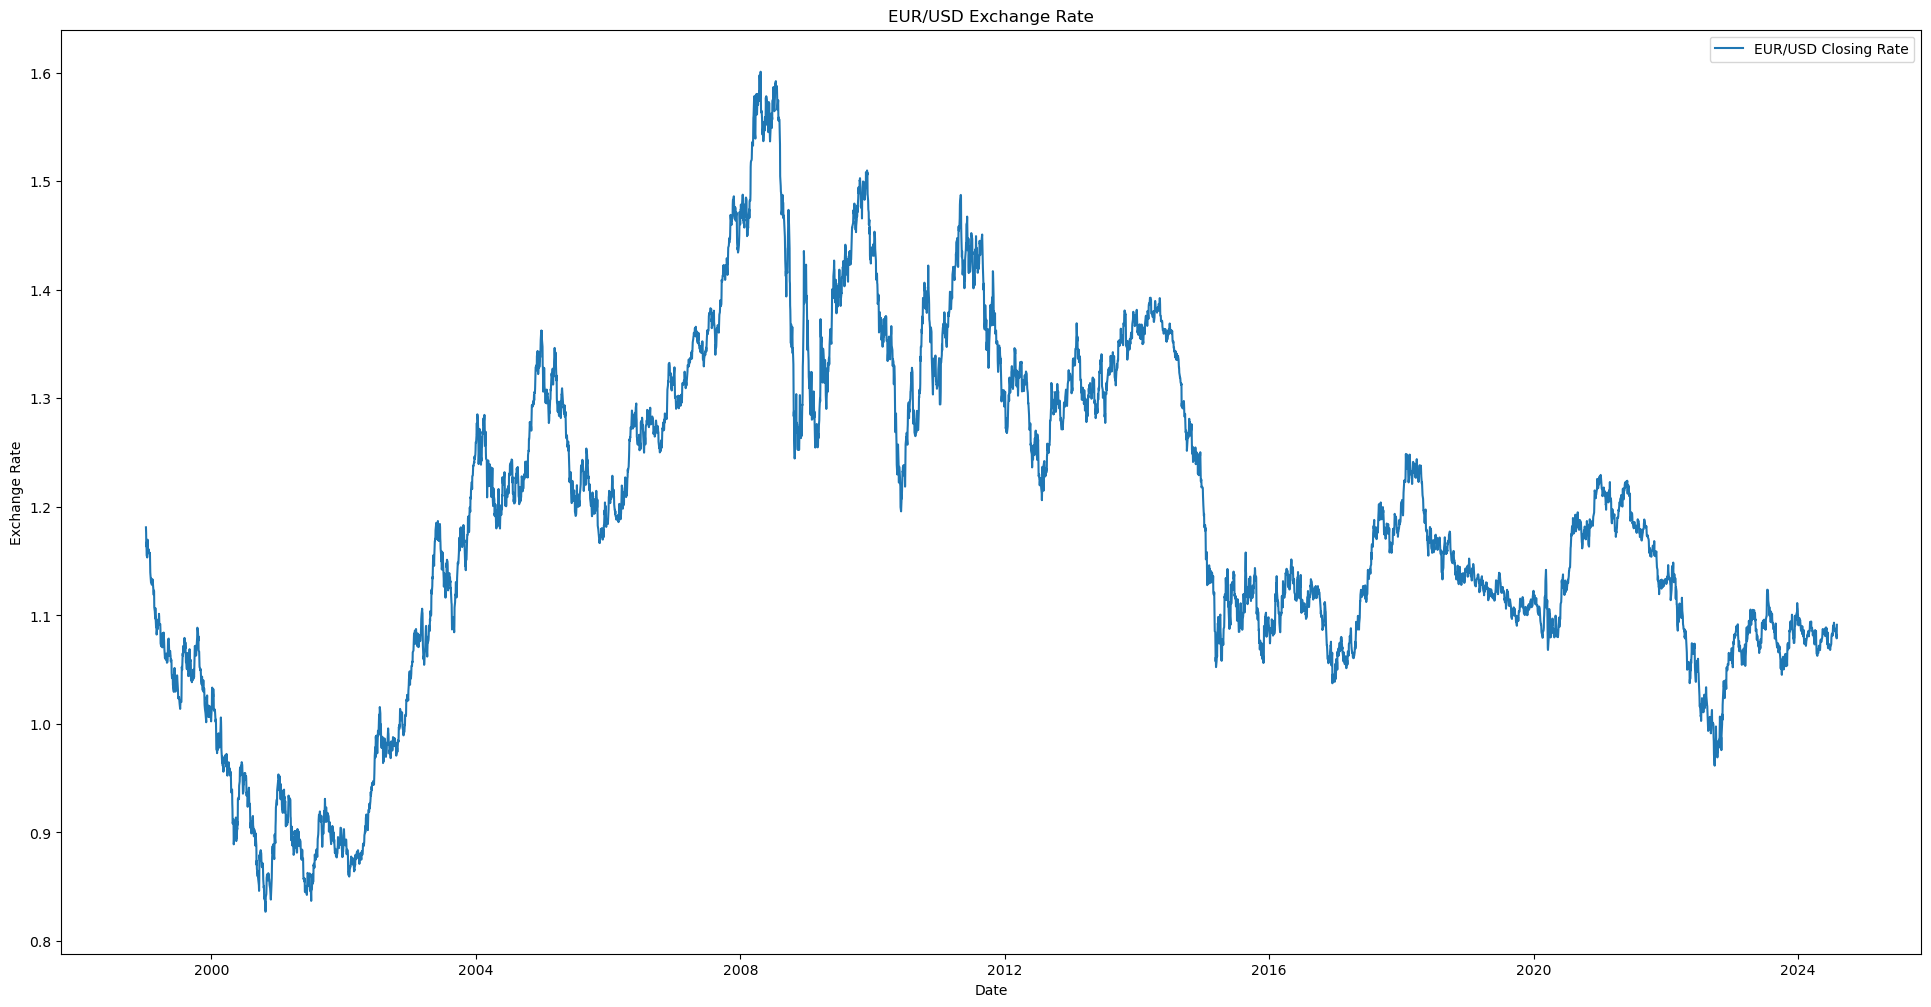

In [63]:
# Plot the FX rate
plt.figure(figsize=(24, 12))
plt.plot(fx_data, label='EUR/USD Closing Rate')
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

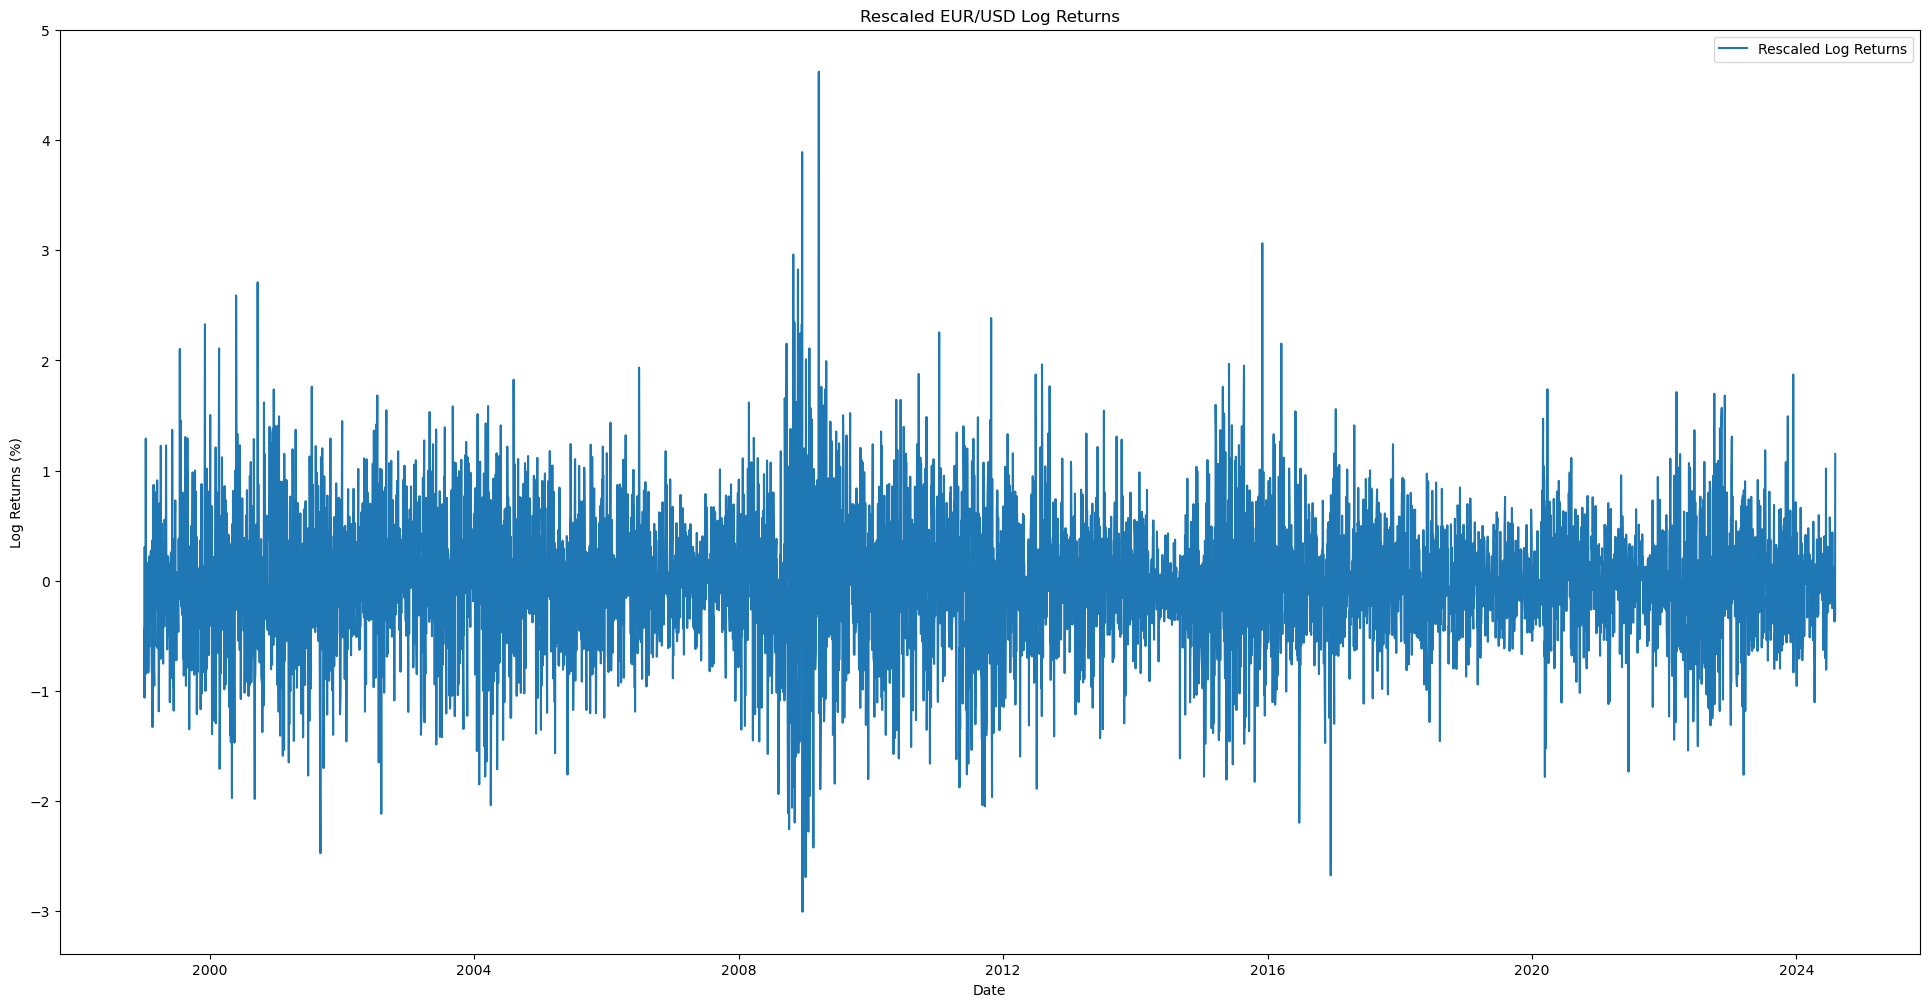

In [64]:
# Calculate log returns
fx_data['Log_Returns'] = np.log(fx_data['EUR/USD']).diff().dropna()

# Rescale log returns by multiplying by 100
fx_data['Log_Returns_Rescaled'] = fx_data['Log_Returns'] * 100

# Plot the rescaled log returns
plt.figure(figsize=(24, 12))
plt.plot(fx_data['Log_Returns_Rescaled'], label='Rescaled Log Returns')
plt.title('Rescaled EUR/USD Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns (%)')
plt.legend()
plt.show()

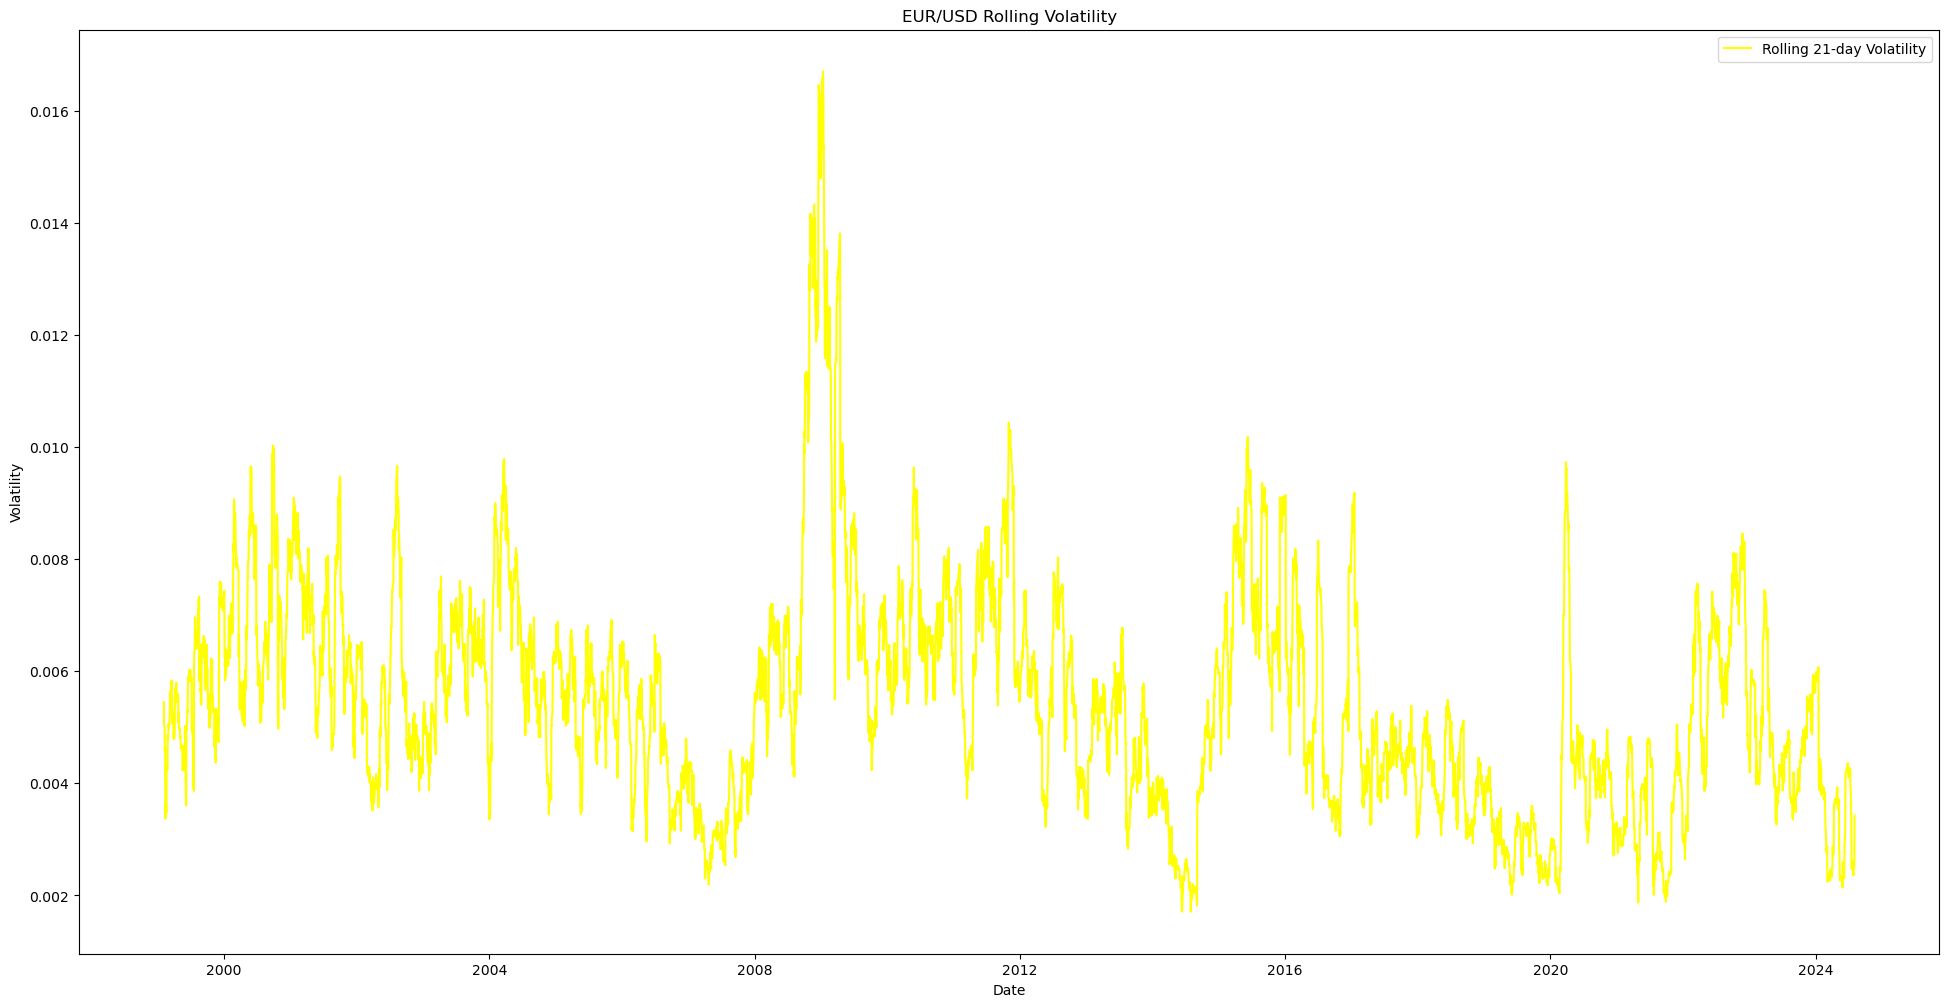

In [65]:
# Plot rolling volatility (standard deviation of returns)
fx_data['Rolling_Volatility'] = fx_data['Log_Returns'].rolling(window=21).std()
plt.figure(figsize=(24, 12))
plt.plot(fx_data['Rolling_Volatility'], label='Rolling 21-day Volatility', color='yellow')
plt.title('EUR/USD Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [66]:
# Fit a GARCH(1,1) model on the rescaled log returns
model = arch_model(fx_data['Log_Returns_Rescaled'].dropna(), vol='Garch', p=1, q=1)
model_fitted = model.fit(disp='off')

# Display model summary
print(model_fitted.summary())

                      Constant Mean - GARCH Model Results                       
Dep. Variable:     Log_Returns_Rescaled   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:               -5176.98
Distribution:                    Normal   AIC:                           10362.0
Method:              Maximum Likelihood   BIC:                           10389.0
                                          No. Observations:                 6417
Date:                  Fri, Aug 09 2024   Df Residuals:                     6416
Time:                          13:01:30   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.1251e-04  6.248e-03     

### 1. **Model Overview**
   - **Dependent Variable:** `Log_Returns_Rescaled`
   - **Mean Model:** Constant Mean
   - **Volatility Model:** GARCH(1,1)
   - **Distribution:** Normal
   - **Number of Observations:** 6417
   - **Log-Likelihood:** -5176.98
   - **AIC (Akaike Information Criterion):** 10362.0
   - **BIC (Bayesian Information Criterion):** 10389.0

### 2. **Mean Model (Constant Mean)**
   - **\(\mu\) (mu):** 8.1251e-04 (0.00081251)
   - **Standard Error:** 6.248e-03
   - **t-Statistic:** 0.130
   - **p-Value:** 0.897
   - **95% Confidence Interval:** [-1.143e-02, 1.306e-02]

   **Interpretation:** 
   - The mean of the rescaled log returns (\(\mu\)) is not statistically significant as indicated by the high p-value (0.897), which is much greater than the typical significance level (0.05). This suggests that the mean return is effectively zero and not different from zero in a statistically meaningful way.

### 3. **Volatility Model (GARCH Components)**
   - **\(\omega\) (omega):** 1.0545e-03 (0.0010545)
     - **Standard Error:** 4.809e-04
     - **t-Statistic:** 2.193
     - **p-Value:** 0.028 (significant at 5% level)
     - **95% Confidence Interval:** [1.119e-04, 1.997e-03]
   
   - **\(\alpha_1\) (alpha[1]):** 0.0322
     - **Standard Error:** 3.880e-03
     - **t-Statistic:** 8.300
     - **p-Value:** 1.041e-16 (highly significant)
     - **95% Confidence Interval:** [0.02460, 0.03981]

   - **\(\beta_1\) (beta[1]):** 0.9649
     - **Standard Error:** 4.324e-03
     - **t-Statistic:** 223.132
     - **p-Value:** 0.000 (highly significant)
     - **95% Confidence Interval:** [0.956, 0.973]

   **Interpretation:**
   - **\(\omega\) (omega):** This is the constant term in the variance equation and represents the long-term variance. A significant \(\omega\) indicates the presence of a baseline level of volatility in the series.
   - **\(\alpha_1\) (alpha[1]):** This coefficient measures the impact of past shocks on current volatility (known as the "ARCH effect"). The value of 0.0322 is significant, suggesting that past shocks do have a noticeable impact on current volatility.
   - **\(\beta_1\) (beta[1]):** This measures the persistence of volatility (known as the "GARCH effect"). The value of 0.9649 is very close to 1, indicating that volatility is highly persistent. This means that once a shock impacts volatility, the effect is long-lasting, which is typical in financial time series.

### 4. **Model Implications**
   - The combination of a low \(\alpha_1\) and a high \(\beta_1\) implies that the volatility in the EUR/USD returns is primarily driven by its past values rather than recent shocks. This is characteristic of financial markets where volatility clustering occurs, meaning periods of high volatility tend to be followed by high volatility, and low volatility tends to follow low volatility.
   - The high persistence (\(\beta_1\)) suggests that any significant volatility will decay slowly, which is critical information for risk management and trading strategies.

### 5. **Practical Value**
   - For the investing community, this model can be used to predict future volatility in the EUR/USD exchange rate, which is crucial for risk management, pricing of derivatives, and formulating trading strategies. The statistical significance of the GARCH components implies that the model is a reliable tool for capturing the volatility dynamics of the market.

In summary, the GARCH(1,1) model fitted here effectively captures the key features of financial volatility in the EUR/USD exchange rate, showing high persistence and responsiveness to past volatility. These insights are valuable for investors and traders who need to anticipate market risks and adjust their strategies accordingly.

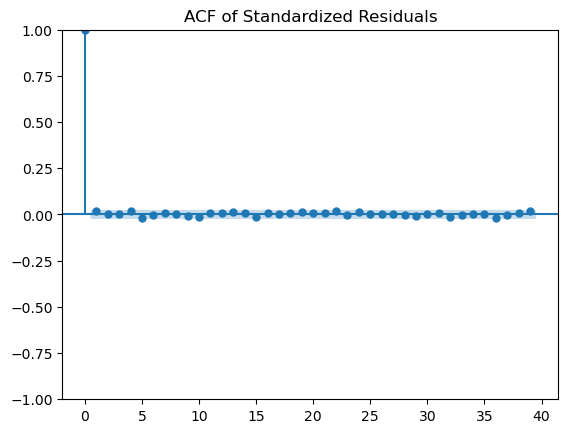

Ljung-Box Test:
      lb_stat  lb_pvalue
10  8.306915   0.598885


In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Standardized residuals
std_residuals = model_fitted.resid / model_fitted.conditional_volatility

# Plot ACF of standardized residuals
plot_acf(std_residuals)
plt.title('ACF of Standardized Residuals')
plt.show()

# Ljung-Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(std_residuals, lags=[10], return_df=True)
print("Ljung-Box Test:\n", lb_test)

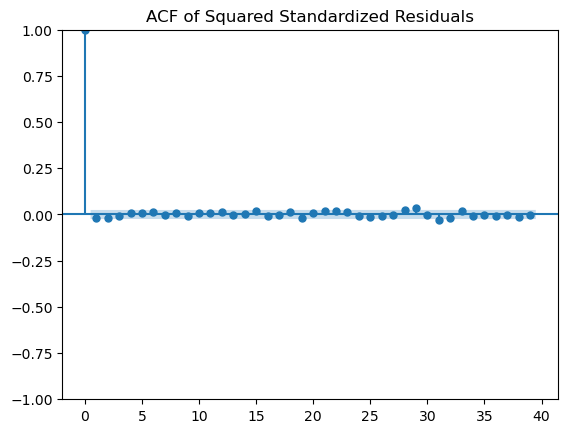

In [68]:
# Plot ACF of squared standardized residuals
plot_acf(std_residuals**2)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

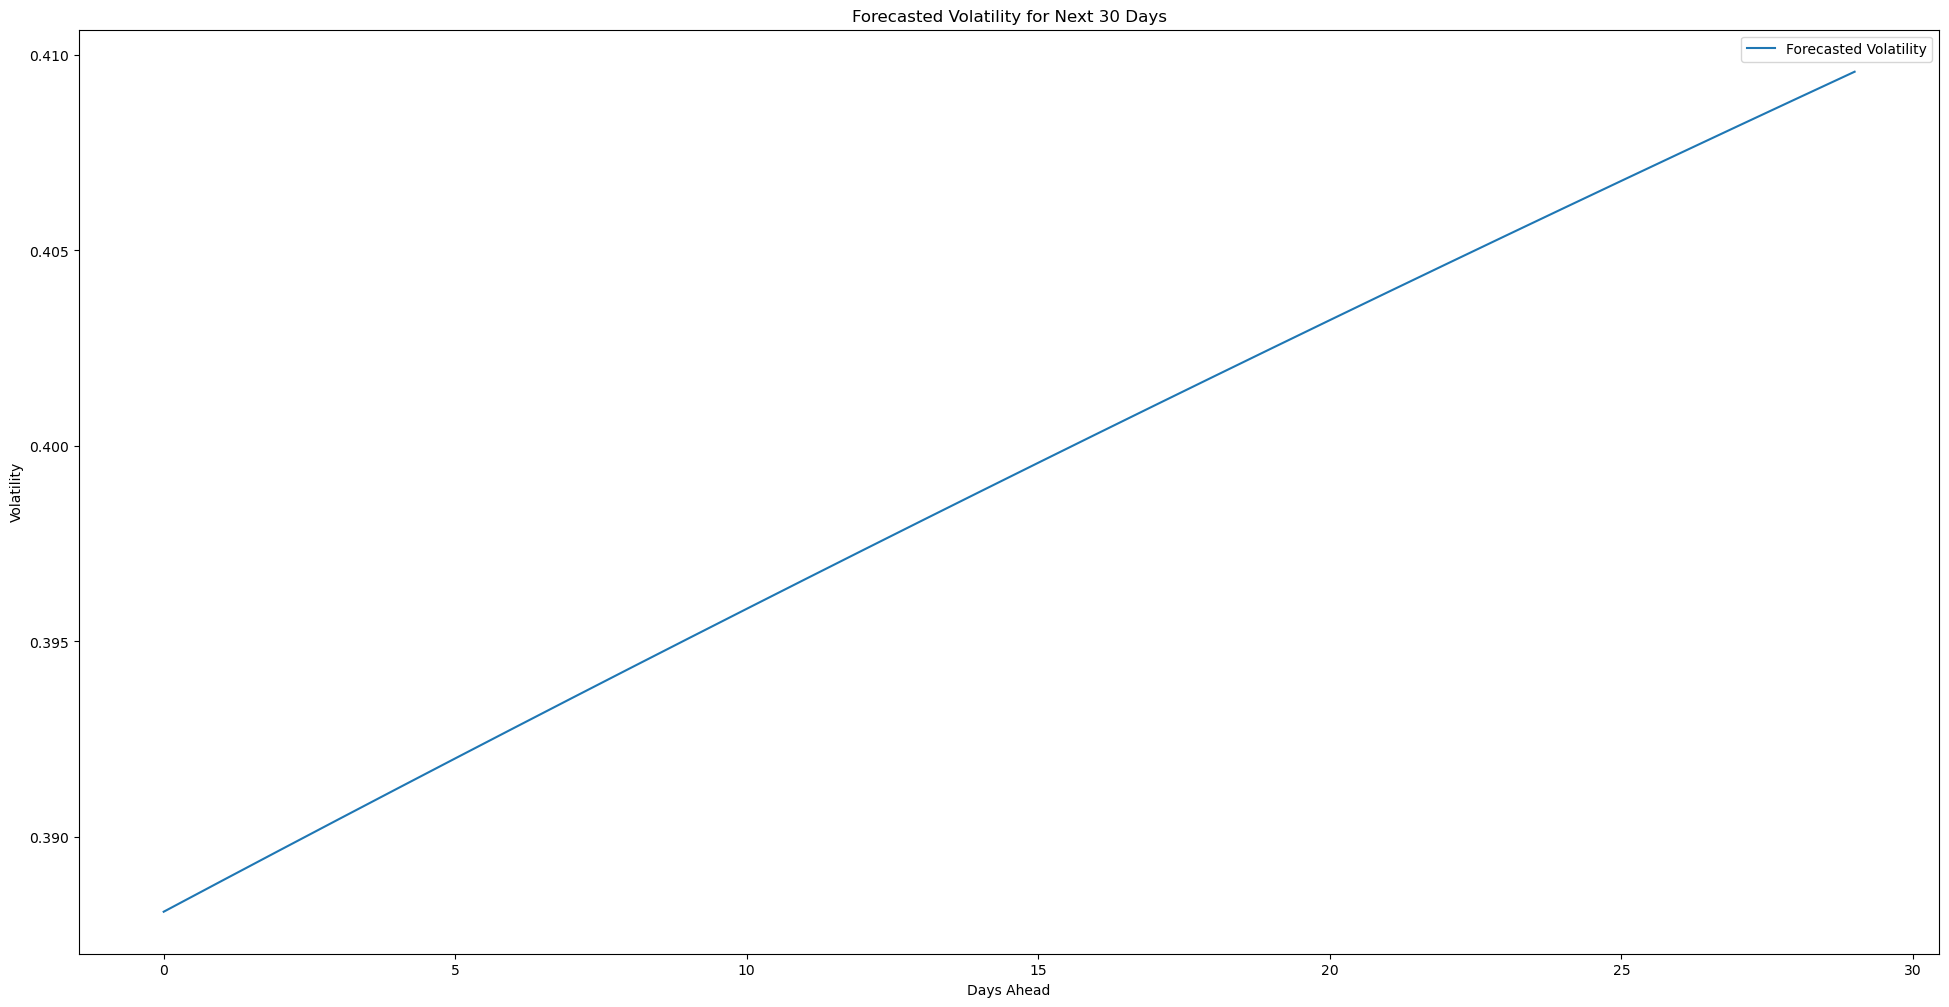

In [69]:
# Forecast future volatility
forecast_horizon = 30  # Forecast the next 30 days
forecast = model_fitted.forecast(horizon=forecast_horizon)

# Extract forecasted volatility
forecasted_volatility = np.sqrt(forecast.variance.values[-1, :])

# Plot forecasted volatility
plt.figure(figsize=(24, 12))
plt.plot(forecasted_volatility, label='Forecasted Volatility')
plt.title('Forecasted Volatility for Next 30 Days')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In this notebook, we applied a GARCH(1,1) model to the EUR/USD exchange rate retrieved from the FRED API to model and forecast volatility. We performed diagnostic checks to ensure the model's accuracy and used the model to forecast future volatility. This approach can help traders and risk managers make more informed decisions by understanding and anticipating changes in market volatility.

### Key Takeaways:
- GARCH models effectively capture volatility clustering in FX rates.
- Accurate volatility forecasts can enhance risk management and trading strategies.
- Model diagnostics are essential to ensure reliability and prevent overfitting.